# Kriging Walkthrough
Video Tutorial: https://youtu.be/mhveiX_d9Q8
Data Source: https://www.epa.gov/outdoor-air-quality-data/download-daily-data


## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

## Read in Houston air quality data

In [2]:
df = pd.read_csv('houston_air_quality.csv')
df = df[['Daily AQI Value','Site Latitude','Site Longitude']]
df

,Daily AQI Value,Site Latitude,Site Longitude
0,47,29.254474,-94.861289
1,47,29.254474,-94.861289
2,42,29.254474,-94.861289
3,46,29.254474,-94.861289
4,22,29.254474,-94.861289
...,...,...,...
1668,37,30.350302,-95.425128
1669,61,30.350302,-95.425128
1670,67,30.350302,-95.425128
1671,61,30.350302,-95.425128


In [3]:
# Extract the necessary columns
latitude = df['Site Latitude'].values
longitude = df['Site Longitude'].values
aqi_value = df['Daily AQI Value'].values

# Setup arrays and grid

In [4]:


# Define the grid for interpolation
gridx = np.linspace(min(longitude) -.35, max(longitude) +.35, 100)
gridy = np.linspace(min(latitude) -.10, max(latitude) + .10, 100)

## Ordinary Kriging

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 133.20236452995147
Full Sill: 420.0901838877157
Range: 1.2000864737031451
Nugget: 286.8878193577642 



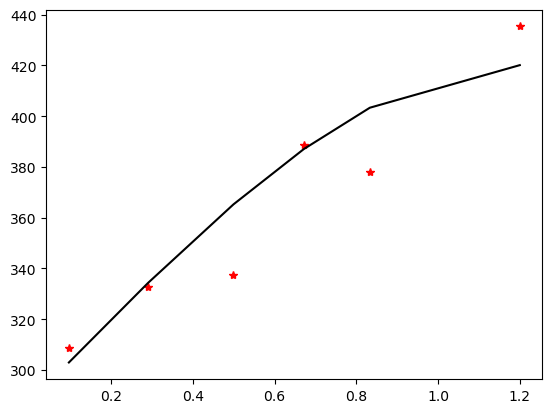

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [5]:
# Perform Ordinary Kriging using the spherical variogram model
OK = OrdinaryKriging(longitude, 
                     latitude, 
                     aqi_value, 
                     variogram_model='spherical', 
                     coordinates_type='geographic', 
                     verbose=True, 
                     enable_plotting=True)
z_interp, ss = OK.execute('grid', gridx, gridy)

## Create overlay image of kriging interpolated values

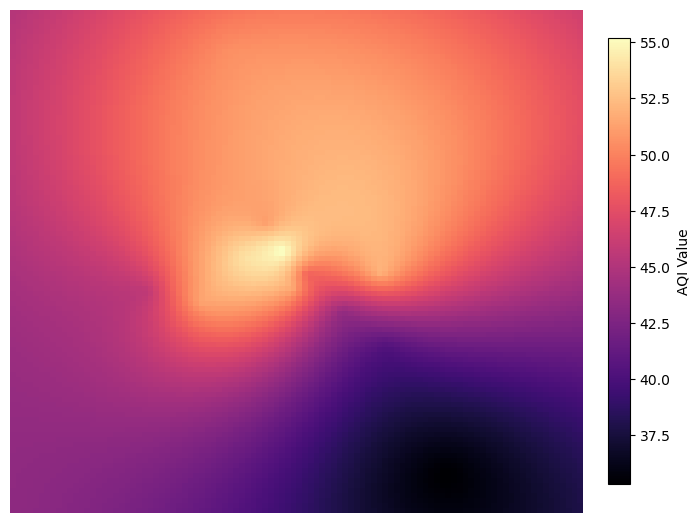

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assuming z_interp, gridx, and gridy are already defined

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the interpolation results
cax = ax.imshow(z_interp, 
                extent=[gridx.min(), 
                        gridx.max(), 
                        gridy.min(), 
                        gridy.max()], 
                origin='lower', 
                cmap='magma', 
                alpha=1)

# Add color bar
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('AQI Value')

# Remove axes
ax.axis('off')

# Save the image
fig.savefig('kriging_interpolation.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Load the image with PIL
image = Image.open('kriging_interpolation.png')

fig

## Create base map with overlayed interpolated data


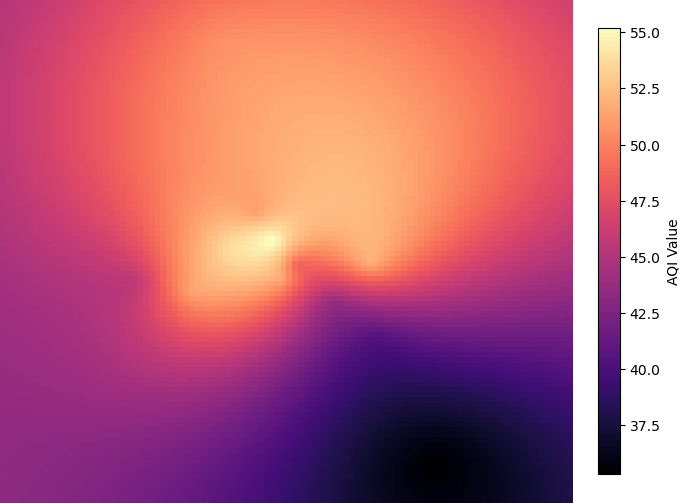

In [8]:
import folium
from folium.raster_layers import ImageOverlay

# Create a base map centered on Houston
m = folium.Map(location=[29.76, -95.37], zoom_start=10)

# Define the bounds where the image will be placed
bounds = [[gridy.min(), gridx.min()], [gridy.max(), gridx.max()]]

# Add the image overlay
image_overlay = ImageOverlay(
    image='kriging_interpolation.png',
    bounds=bounds,
    opacity=.7,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

image_overlay.add_to(m)

# Add points for the measuring stations
for lat, lon in zip(latitude, longitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1
    ).add_to(m)

# Save the map to an HTML file
m.save('houston_kriging_map_with_mesh.html')

# Display the map
m
